In [1]:
class Token:       
    def __init__(self):
        self.balances = {}
        self.totalSupply = 0
    
    def mint(self, address, amount):
        assert(amount > 0)
        self.balances[address] = self.balances.get(address, 0) + amount
        self.totalSupply += amount
    
    def balanceOf(self, address):
        return self.balances.get(address, 0)
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        if self.balanceOf(sender) >= amount:
            self.balances[sender] = self.balances.get(sender, 0) - amount
            self.balances[recipient] = self.balances.get(recipient, 0) + amount    
            return True
        else:
            return False

In [2]:
token = Token()
token.mint("A", 5)
assert(token.balanceOf("A") == 5)

token.transferFrom("A", "B", 3)
assert(token.balanceOf("B") == 3)
assert(token.balanceOf("A") == 2)

token.transferFrom("A", "C", 2)
assert(token.balanceOf("A") == 0)
assert(token.balanceOf("C") == 2)

In [215]:
import time 
import decimal
from decimal import Decimal 
math = decimal.Context()

# class InterestToken
#  __init__(rate, _rateAccumulator)
#  balanceOfUnderlying(address)
#  accrueInterest()
#  updateRate(update)
#  yearlyRate()

class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        self.block += 1
        self.timestamp += 15
    
    def updateTimestamp(self, _timestamp):
        self.timestamp = _timestamp
    
    def now(self):
        return self.timestamp


class InterestToken(Token):
    # rate is a yearly rate, converted to a rate compounded per second
    def __init__(self, _blockchain, rate, _rateAccumulator):
        Token.__init__(self)
        self.blockchain = _blockchain
        self.lastUpdate = self.blockchain.now()
        self.rateAccumulator = _rateAccumulator
        # 31622400 is the number of seconds in a year
        self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400))  
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator
    
    def transferUnderlying(self, sender, recipient, amount):
        value = amount / self.rateAccumulator
        self.transferFrom(sender, recipient, value)
        
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.lastUpdate = now
    
    def updateRate(self, update):
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
    
    def yearlyRate(self):
        return math.power(self.rate, Decimal(31622400)) - 1

In [198]:
chain = blockchain(0,1)
token = InterestToken(chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
chain.updateTimestamp(31622400)
token.accrueInterest()
token.balanceOfUnderlying("A")
assert(int(token.balanceOfUnderlying("A")) == 1020)

In [199]:
chain = blockchain(0,1)
token = InterestToken(chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
# Note that the per second rates are multiplied, not added
token.updateRate(.001)
token.updateRate(.001)
token.updateRate(-.001)
token.updateRate(.001)
token.updateRate(.001)
#print(token.yearlyRate())
chain.updateTimestamp(31622400)
print(token.rate)
token.accrueInterest()
assert(int(token.balanceOfUnderlying("A")) == 1023)

1.000000000721011950427853002


In [200]:
chain = blockchain(1,1)
uToken = InterestToken(chain, .04, 1)
for x in range(10000):
    chain.incrementBlock()
    uToken.accrueInterest()

uToken.rateAccumulator


Decimal('1.000186059700104401460770319')

In [498]:
# class Queueball: 
#   __init__(self, _uToken : Token , _sToken : Token)
#   check_user(self, address)
#   sell_underlying_for_synthetic(self, address, amount)
#   withdraw_synthetic(self, address)
#   sell_synthetic_for_underlying(self, address, amount)
#   withdraw_underlying(self, address)

class Queueball:
    def __init__(self, _uToken : Token , _sToken : Token):
        self.uToken = _uToken
        self.sToken = _sToken
        self.underlying = 0
        self.synthetic  = 0
        self.address = "queueball"
        self.book = {}
    
    def check_user(self, address):
        if not address in self.book:
            self.book[address] = {'s': [], 'u': []}
        
    def transferToken(self, token, sender, recipient, amount):
        return token.transferUnderlying(sender, recipient, amount)
    
    def sell_underlying_for_synthetic(self, address, amount):
        self.transferToken(uToken, address, self.address, amount)
        if (self.underlying + amount) > self.synthetic:
            self.check_user(address)
            self.book[address]['u'].append({'amount': amount, 'height': self.underlying + amount})
            self.underlying += amount
        else:
            self.transferToken(sToken, self.address, address, amount)
            self.underlying += amount
        
    def sell_synthetic_for_underlying(self, address, amount):
        self.transferToken(sToken, address, self.address, amount)
        if (self.synthetic + amount) > self.underlying:
            # add to book
            self.check_user(address)
            self.book[address]['s'].append({'amount': amount, 'height': self.synthetic + amount})
            self.synthetic += amount
        else:
            # execute immediately
            self.transferToken(uToken, self.address, address, amount)
            self.synthetic += amount

    def withdraw_synthetic(self, address):
        self.check_user(address)
        remaining_orders = []
        for order in self.book[address]['u']:
            if self.synthetic >= order['height']:
                self.transferToken(sToken, self.address, address, order['amount'])
            else:
                remaining_orders.append(order)
        self.book[address]['u'] = remaining_orders
        
    def withdraw_underlying(self, address):
        self.check_user(address)
        remaining_orders = []
        for order in self.book[address]['s']:
            if self.underlying >= order['height']:
                self.transferToken(uToken, self.address, address, order['amount'])
            else:
                remaining_orders.append(order)
        self.book[address]['s'] = remaining_orders
        
    def order_value(self, address):
        total = 0
        for order in self.book[address]['s']:
            total += order['amount']
        for order in self.book[address]['u']:
            total += order['amount']
        return total

In [191]:
# Test out Queueball
chain = blockchain(1,1)
uToken = InterestToken(chain, 0,1)
sToken = InterestToken(chain, 0,1)
queue = Queueball(uToken, sToken)
uToken.mint("A", 1000)
sToken.mint("B", 1000)

# Test 1
queue.sell_underlying_for_synthetic("A", 100)
queue.sell_synthetic_for_underlying("B", 100)
queue.withdraw_synthetic("A")
queue.withdraw_synthetic("B") # should not do anything
queue.withdraw_underlying("A") # should not do anything
queue.withdraw_underlying("B") # should not do anything
assert(uToken.balanceOfUnderlying("A") ==  900)
assert(uToken.balanceOfUnderlying("B") ==  100)
assert(sToken.balanceOfUnderlying("A") ==  100)
assert(sToken.balanceOfUnderlying("B") ==  900)

#Test 2
queue.sell_underlying_for_synthetic("A", 100)
queue.sell_synthetic_for_underlying("B", 150)
queue.withdraw_synthetic("A")
queue.withdraw_synthetic("B") # should not do anything
queue.withdraw_underlying("A") # should not do anything
queue.withdraw_underlying("B") # should not do anything
assert(uToken.balanceOfUnderlying("A") ==  800)
assert(uToken.balanceOfUnderlying("B") ==  100)
assert(sToken.balanceOfUnderlying("A") ==  200)
assert(sToken.balanceOfUnderlying("B") ==  750)

#Test 3
queue.sell_underlying_for_synthetic("A", 100)
queue.withdraw_synthetic("A") # should not do anything
queue.withdraw_synthetic("B") # should not do anything
queue.withdraw_underlying("A") # should not do anything
queue.withdraw_underlying("B")
assert(uToken.balanceOfUnderlying("A") ==  700)
assert(uToken.balanceOfUnderlying("B") ==  250)
assert(sToken.balanceOfUnderlying("A") ==  200)
assert(sToken.balanceOfUnderlying("B") ==  750)

In [192]:
# Further Test out Queueball
chain = blockchain(1,1)
uToken = InterestToken(chain, 0,1)
sToken = InterestToken(chain, 0,1)
queue = Queueball(uToken, sToken)
uToken.mint("C", 1000)
uToken.mint("D", 1000)
uToken.mint("E", 1000)
sToken.mint("C", 1000)
sToken.mint("D", 1000)
sToken.mint("E", 1000)
# You can permute the following in any order and the tests should still pass

queue.sell_underlying_for_synthetic("C", 100)
queue.sell_underlying_for_synthetic("E", 200)
queue.sell_underlying_for_synthetic("D", 200)
queue.sell_synthetic_for_underlying("D", 300)
queue.sell_underlying_for_synthetic("E", 300)
queue.sell_synthetic_for_underlying("E", 100)
queue.sell_synthetic_for_underlying("E", 400)

#######
queue.withdraw_synthetic("C")
queue.withdraw_synthetic("D")
queue.withdraw_synthetic("E")
queue.withdraw_underlying("C")
queue.withdraw_underlying("D")
queue.withdraw_underlying("E")
assert(uToken.balanceOfUnderlying("C") ==  900)
assert(uToken.balanceOfUnderlying("D") ==  1100)
assert(uToken.balanceOfUnderlying("E") ==  1000)
assert(sToken.balanceOfUnderlying("C") ==  1100)
assert(sToken.balanceOfUnderlying("D") ==  900)
assert(sToken.balanceOfUnderlying("E") ==  1000)

## Simulate

In [607]:
import numpy
import random

chain = blockchain(1,1)
uToken = InterestToken(chain, .04, 1)
sToken = InterestToken(chain, .04, 1)
queue = Queueball(uToken, sToken)
finalU = {}
finalS = {}
for x in range(10):
    uToken.mint(x, Decimal(1000000000))
    sToken.mint(x, Decimal(1000000000))
    finalU[x] = Decimal(1000000000)
    finalS[x] = Decimal(1000000000)
    
interestUpdateAmount = 0.0001
ratesPerBlock = []
ordersOutstanding = []

arbitrage_user = 'arb'
uToken.mint(arbitrage_user, Decimal(10000000000))
sToken.mint(arbitrage_user, Decimal(10000000000))
arb_value = []
arb_syn = []
arb_und = []

buyVsSella = 0
buyVsSell = []
traded = 0
    
for block in range(10000):
    # perform interest rate update at beginning of block
    chain.incrementBlock()

    if queue.underlying > queue.synthetic:
        # lower interest rate
        sToken.updateRate(-interestUpdateAmount)
    elif  queue.synthetic > queue.underlying:
        # raise interest rate
        sToken.updateRate(interestUpdateAmount)
    
    ratesPerBlock.append(sToken.yearlyRate())
    #ratesPerBlock.append(sToken.rate)
    ordersOutstanding.append(queue.underlying - queue.synthetic)
    
    # perform a random trade
    amount = Decimal(int(numpy.random.lognormal(11, 3)))
    user = random.choice(range(10))
    if random.choice(["buy","sell"]) == "buy":
        if uToken.balanceOfUnderlying(user) > amount:
            queue.sell_underlying_for_synthetic(user, amount)
            finalS[user] += amount
            finalU[user] -= amount
            buyVsSella -= amount
            
    else:
        if sToken.balanceOfUnderlying(user) > amount:
            queue.sell_synthetic_for_underlying(user, amount)
            finalU[user] += amount
            finalS[user] -= amount
            buyVsSella += amount
            
    buyVsSell.append(buyVsSella)
    queue.withdraw_synthetic(user)
    queue.withdraw_underlying(user)
    # let an arbitrage agent make a trade
    if True: 
        
        #amount = min(Decimal(int(numpy.random.lognormal(11, 3))), uToken.balanceOfUnderlying(arbitrage_user))
        if (uToken.yearlyRate() - sToken.yearlyRate()) > 0.04 :
            # lower interest rate
            desired = max(Decimal(0), 
                          Decimal(queue.underlying - queue.synthetic))
            amount = min(desired, sToken.balanceOfUnderlying(arbitrage_user))
            #if amount == Decimal(0):
            #    amount = Decimal(10000000)
            queue.sell_synthetic_for_underlying(arbitrage_user, Decimal(amount))
            traded += amount
        elif (sToken.yearlyRate() - uToken.yearlyRate()) > 0.04:
            desired = max(Decimal(0),  
                          Decimal( queue.synthetic - queue.underlying))
            amount = min(desired, uToken.balanceOfUnderlying(arbitrage_user))
            #if amount == Decimal(0):
            #    amount = Decimal(10000000)
            queue.sell_underlying_for_synthetic(arbitrage_user, Decimal(amount)) 
            traded -= amount

        queue.withdraw_synthetic(arbitrage_user)
        queue.withdraw_underlying(arbitrage_user)
        arb_value.append(int(sToken.balanceOfUnderlying(arbitrage_user) + \
                         uToken.balanceOfUnderlying(arbitrage_user) + \
                         queue.order_value(arbitrage_user)))
        #arb_value.append(traded)
        arb_syn.append(sToken.balanceOfUnderlying(arbitrage_user))
        arb_und.append(uToken.balanceOfUnderlying(arbitrage_user))
    
    # final behavior at end of block
    uToken.accrueInterest()
    sToken.accrueInterest()

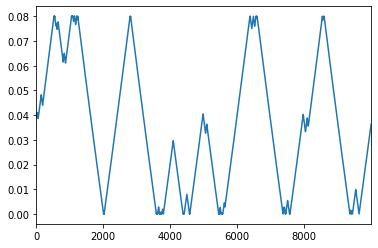

In [608]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
s = pandas.Series(pandas.to_numeric(ratesPerBlock))
s.plot()

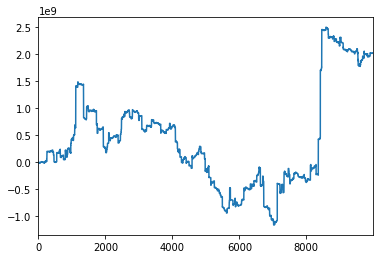

In [609]:
t = pandas.Series(pandas.to_numeric(buyVsSell))
t.plot()

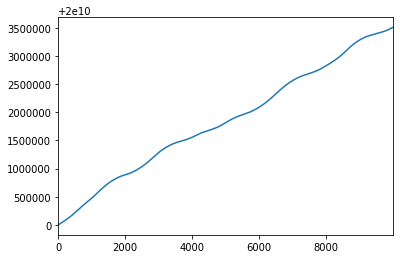

In [610]:
f = pandas.Series(pandas.to_numeric(arb_value))
f.plot()

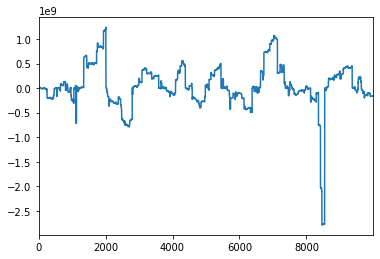

In [611]:
o = pandas.Series(pandas.to_numeric(ordersOutstanding))
o.plot()

In [612]:
arb_value[-1]/arb_value[0]

1.00017554555

In [613]:
sToken.rateAccumulator

Decimal('1.000166390173918467456588861')

In [614]:
uToken.rateAccumulator

Decimal('1.000186059700104401460770319')

In [507]:
ratesPerBlock[-1]

Decimal('0.033727501488361251126852937')

In [427]:
ratesPerBlock[6000] > 0.01

True

In [473]:
abs(Decimal(-5))

Decimal('5')

In [474]:
min(1,2,3)

1